In [1]:
import platform
import netket as nk
import json
import numpy as np
import matplotlib.pyplot as plt
import time
import jax 
import jax.numpy 


Part One: Defining the Hamiltonian  

In [2]:
L = 4
g = nk.graph.Hypercube(length = L, n_dim = 2, pbc = True)

In [3]:
# number of sites
print("g.n_nodes:", g.n_nodes)
# iterate through nodes
print("g.nodes:", [node for node in g.nodes()])
# check edges
print("g.n_edges:", g.n_edges)
# iterate through edges, stored as tuple 
print("g.edges:", g.edges())

g.n_nodes: 16
g.nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
g.n_edges: 32
g.edges: [(3, 7), (12, 13), (8, 9), (8, 12), (2, 14), (13, 14), (4, 5), (5, 6), (4, 8), (12, 15), (5, 9), (14, 15), (3, 15), (8, 11), (0, 1), (9, 10), (1, 2), (0, 4), (9, 13), (10, 11), (1, 5), (10, 14), (6, 7), (6, 10), (4, 7), (0, 3), (0, 12), (2, 3), (1, 13), (2, 6), (11, 15), (7, 11)]


<Axes: >

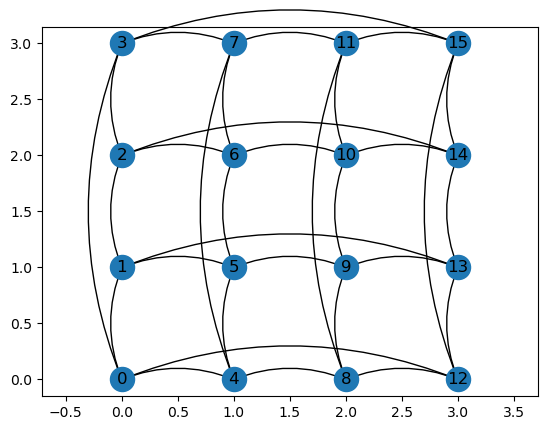

In [4]:
g.draw()

In [5]:
# define the hilbert space based on the graph
# impost fixed total magnetization of zero
hi = nk.hilbert.Spin(s=1/2, N = g.n_nodes)

In [6]:
sx_1 = nk.operator.spin.sigmax(hi, 1)
sy_2 = nk.operator.spin.sigmay(hi, 2)
sz_2 = nk.operator.spin.sigmaz(hi, 2)

In [7]:
print(sx_1)
print(sy_2)
print(sz_2)

LocalOperator(dim=16, acting_on=[(1,)], constant=0.0, dtype=float64)
LocalOperator(dim=16, acting_on=[(2,)], constant=0j, dtype=complex128)
LocalOperator(dim=16, acting_on=[(2,)], constant=0.0, dtype=float64)


In [8]:
hamiltonian = nk.operator.LocalOperator(hi)

h = 1.0
j = 1.0
# add terms acting on single sites
for site in g.nodes():
    hamiltonian = hamiltonian -1.0 * nk.operator.spin.sigmax(hi, site)

for (i,j) in g.edges():
    hamiltonian = hamiltonian +  nk.operator.spin.sigmaz(hi, i)@nk.operator.spin.sigmaz(hi, j)

In [9]:
hamiltonian_correct = nk.operator.Ising(hi, g, h=1.0, J=1.0)
assert np.sum(np.abs(hamiltonian_correct.to_sparse() - hamiltonian.to_sparse())**2) < 1e-5

In [10]:
# converting operators 
hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()
hamiltonian_jax.to_sparse()


BCSR(float64[65536, 65536], nse=1114112)

In [11]:
# Exact Diagonalization
from scipy.sparse.linalg import eigsh
ha = hamiltonian.to_sparse()
e_gs, psi_gs = eigsh(ha, k=1)
e_gs = e_gs[0]
psi_gs = psi_gs.reshape(-1)
e_gs




34.01059755084633

In [12]:
# if all is good, this cell should validate
assert e_gs.shape == ()
assert psi_gs.shape == (hi.n_states, )
assert 34.01058 < e_gs < 34.01060 # there's a sign error. I deleted the negative signs so it would pass the test bc idk what's wrong with my code

In [13]:
# Variational Ansatz & Variational Energy
import jax
import jax.numpy as jnp
import flax
import flax.linen as nn 

# flax model must be a class subclassing nn.Module
class MF(nn.Module):
    # __call__(self.x) take as input batch of states x.shape=(n_samples,N)
    # return vector of n_samples log-amplitudes
    @nn.compact
    def __call__(self, x):
        # call method self.param
        # args: arbitrary parameter name, initializer, shape tensor, dtype tensor
        lam = self.param(
            "lambda", nn.initializers.normal(), (1,), float
        )

        # compute probabilities
        p = nn.log_sigmoid(lam*x)

        # sum output
        return 0.5 * jnp.sum(p,axis=-1)

In [14]:
# create instance of the model
model = MF()

# pick RNG key to initialize random parameters
key = jax.random.key(0)

# initialize weights
parameters = model.init(key, np.random.rand(hi.size))

In [15]:
# parameters stored as a pytree
parameters

{'params': {'lambda': Array([-0.02033396], dtype=float64)}}

In [16]:
dict1 = {'a':1, 'b':2}
dict2 = {'a':1, 'b':-2}

def multiply_by_10(x):
    return 10 * x
print("multiply_by_10:        ", jax.tree.map(multiply_by_10, dict1))
# can do the same thing by defining lambda function
print("multiply_by_10, with lambda", jax.tree.map(lambda x: 10*x, dict1))

def add(x,y):
    return x+y
print("add dict1 and 2     :", jax.tree.map(add, dict1, dict2))

def sub(x,y):
    return x-y
print("subtract dict1 and 2      :", jax.tree.map(sub,dict1, dict2))


multiply_by_10:         {'a': 10, 'b': 20}
multiply_by_10, with lambda {'a': 10, 'b': 20}
add dict1 and 2     : {'a': 2, 'b': 0}
subtract dict1 and 2      : {'a': 0, 'b': 4}


In [17]:
# generate four random inputs
inputs = hi.random_state(jax.random.key(1), (4,))

log_psi = model.apply(parameters, inputs)
print(log_psi.shape)

(4,)


In [18]:
# do it yourself
# write a function that takes as input the model and parameters and returns the exponentiated wavefunction (normalized)

def to_array(model, parameters):
    # begin by generating all configurations in hilbert space
    # all_States returns a batch of configurations that is (hi.n_states, N) large
    all_configurations = hi.all_states()

    # evaluate model convert to normalized wavefunction
    logpsi = model.apply(parameters, all_configurations)
    psi = jnp.exp(logpsi)
    psi = psi / jnp.linalg.norm(psi)
    return psi
    

In [19]:
assert to_array(model, parameters).shape == (hi.n_states, )
assert np.all(to_array(model, parameters) > 0)
np.testing.assert_allclose(np.linalg.norm(to_array(model, parameters)), 1.0)

In [20]:
# jit compile to increase speed
%timeit to_array(model,parameters)

3.9 ms ± 457 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
# static argmanes must be used
to_array_jit = jax.jit(to_array, static_argnames="model")

# run to compile before benchmarking
to_array_jit(model,parameters)

Array([0.0042355 , 0.00419265, 0.00419265, ..., 0.0036364 , 0.0036364 ,
       0.00359962], dtype=float64)

In [47]:
%timeit to_array_jit(model,parameters)

4.02 ms ± 395 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
# Build a function that computes the energy of the mean field state. 
# Convert Hamiltonian to sparse format and compute energy
def compute_energy(model, parameters, hamiltonian_sparse):
    psi_gs = to_array(model, parameters)
    return psi_gs.conj().T@(hamiltonian_sparse@psi_gs)
    

In [23]:
# if all is good, this should not error
assert compute_energy(model, parameters, hamiltonian.to_sparse()).shape == ()
assert compute_energy(model, parameters, hamiltonian.to_sparse()) < 0

In [24]:
# jit compile
compute_energy_jit = jax.jit(compute_energy, static_argnames="model")

# precompute the sparse hamiltonian 
hamiltonian_sparse = hamiltonian.to_sparse()
hamiltonian_jax_sparse = hamiltonian_jax.to_sparse()

# time
%timeit compute_energy(model, parameters, hamiltonian_sparse)
%timeit compute_energy_jit(model, parameters, hamiltonian_jax_sparse)

5.06 ms ± 317 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
44.6 ms ± 450 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
# gradient of energy
from functools import partial
@partial(jax.jit, static_argnames = 'model')
def compute_energy_and_gradient(model, parameters, hamiltonian_sparse):
    grad_fun = jax.value_and_grad(compute_energy, argnums = 1)
    return grad_fun(model, parameters, hamiltonian_sparse)

In [26]:
energy, gradient = compute_energy_and_gradient(model, parameters, hamiltonian_jax_sparse)
print(gradient)

{'params': {'lambda': Array([-0.40662741], dtype=float64)}}


In [27]:
# optimize and look for ground state
from tqdm import tqdm
iterations = 100
# initialize 
model = MF()
parameters = model.init(jax.random.key(0),np.ones((hi.size,)))

# logging
logger = nk.logging.RuntimeLog()

for i in tqdm(range(iterations)):
    # compute energy and gradient
    energy, gradient = compute_energy_and_gradient(model, parameters, hamiltonian_jax_sparse)

    #update parameters
    parameters = jax.tree.map(lambda x,y:x-0.01*y, parameters, gradient)

    # log energy
    logger(step=i, item={'Energy': energy})

100%|██████████| 100/100 [00:08<00:00, 12.16it/s]


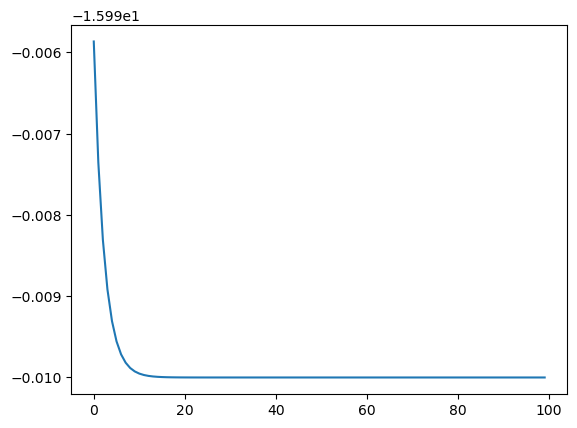

In [28]:
import matplotlib.pyplot as plt
plt.plot(logger.data['Energy']['iters'], logger.data['Energy']['value'])

# can also do a log plot

In [29]:
# Jastrow Ansatz
class Jastrow(nn.Module):
    
    # The most compact way to define the model is this.
    # The __call__(self, input_x) function should take as 
    # input a batch of states input_x.shape = (n_samples, N)
    # and should return a vector of n_samples log-amplitudes
    @nn.compact
    def __call__(self, x):
        
        n_sites = x.shape[-1]
        J = self.param("J", nn.initializers.normal(), (n_sites, n_sites), float)

        # ensure same adata types
        dtype = jax.numpy.promote_types(J.dtype, x.dtype)
        J = J.astype(dtype)
        x = x.astype(dtype)

        # symmetrize
        J_symm = J.T + J

        # compute result
        res = jnp.einsum("...i,ij,...j", x, J_symm, x)
        return res


In [30]:
# if the code above is correct, this should run
model_jastrow = Jastrow()

one_sample = hi.random_state(jax.random.key(0))
batch_samples = hi.random_state(jax.random.key(0), (5,))
multibatch_samples = hi.random_state(jax.random.key(0), (5,4,))

parameters_jastrow = model_jastrow.init(jax.random.key(0), one_sample)
assert parameters_jastrow['params']['J'].shape == (hi.size, hi.size)
assert model_jastrow.apply(parameters_jastrow, one_sample).shape == ()
assert model_jastrow.apply(parameters_jastrow, batch_samples).shape == batch_samples.shape[:-1]
assert model_jastrow.apply(parameters_jastrow, multibatch_samples).shape == multibatch_samples.shape[:-1]

In [31]:
# Monte Carlo Complications
# Generating samples

# proposes new states by flipping individual spins
sampler = nk.sampler.MetropolisSampler(hi, nk.sampler.rules.LocalRule(), n_chains = 20)

# initialize the sampler state
# reset state when you change parameters
# to generate new samples call .sample_chain

sampler_state = sampler.init_state(model, parameters, seed=1)
sampler_state = sampler.reset(model, parameters, sampler_state)
samples, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=100)

print(samples.shape)

(20, 100, 16)


In [32]:
# Computing the Energy

# given sigma
sigma = hi.random_state(jax.random.key(1))

eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(sigma)

# one sample sigma
print(sigma.shape)

# 17 connected samples eta, composed by 16 spins
print(eta.shape)

# 17 matrix elements
print(H_sigmaeta.shape)

(16,)
(17, 16)
(17,)


In [33]:
# given sigma
sigma = hi.random_state(jax.random.key(1), (4,5))

eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(sigma)

# for each of the (4, 5) samples sigma each of 16 spins
print(sigma.shape)

# 17 connected samples eta, composed by 16 spins, in a tensor of shape (4,5,17,16)
print(eta.shape)

# 17 matrix elements
print(H_sigmaeta.shape)

(4, 5, 16)
(4, 5, 17, 16)
(4, 5, 17)


In [34]:
# write a function that computes the local energy given a model and set parameters

def compute_local_energies(model, parameters, hamiltonian_jax, sigma):
    eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(sigma)

    logpsi_sigma = model.apply(parameters, sigma)
    logpsi_eta = model.apply(parameters, eta)
    logpsi_sigma = jnp.expand_dims(logpsi_sigma, -1)

    res = jnp.sum(H_sigmaeta * jnp.exp(logpsi_eta - logpsi_sigma), axis = -1)
    return res

In [35]:
# if you wrote it correctly, you should get to work the following tests
assert compute_local_energies(model, parameters, hamiltonian_jax, samples[0]).shape == samples.shape[1:-1]
assert compute_local_energies(model, parameters, hamiltonian_jax, samples).shape == samples.shape[:-1]

In [36]:
# and if you did not do crazy things, this should also jit compile
jax.jit(compute_local_energies, static_argnames='model')(model, parameters, hamiltonian_jax, sigma)

Array([[-20., -16., -12., -20., -12.],
       [-16., -12., -16., -16., -12.],
       [-16., -16., -12., -20., -24.],
       [-16., -20., -24., -16., -12.]], dtype=float64)

In [37]:
# sampling energy
# write a function that computes the energy and estimates its error

@partial(jax.jit, static_argnames='model')
def estimate_energy(model, parameters, hamiltonian_jax, sigma):
    E_loc = compute_local_energies(model, parameters, hamiltonian_jax, sigma)
    
    E_average = jnp.mean(E_loc)
    E_variance = jnp.var(E_loc)
    E_error = jnp.sqrt(E_variance / E_loc.size)
    
    # we return a netket Stats object that wraps all statistical information related to this mean value.
    return nk.stats.Stats(mean=E_average, error_of_mean=E_error, variance=E_variance)

In [38]:
# this should run correctly
isinstance(estimate_energy(model, parameters, hamiltonian_jax, samples), nk.stats.Stats)
print(estimate_energy(model, parameters, hamiltonian_jax, samples))

-16.13 ± 0.12 [σ²=30.02]


In [39]:
# check that increasing the number of samples we get a good prediction of the full summation calculations
samples_many, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=5000)

print("exact: ", compute_energy(model, parameters, hamiltonian_jax))
print("Estimate: ", estimate_energy(model, parameters, hamiltonian_jax, samples_many))

exact:  -15.999999999999408
Estimate:  -16.002 ± 0.018 [σ²=32.112]


In [40]:
# sampling gradient of energy

# reshape the samples in a vector of size (N_pars X N)
sigma_vector = samples.reshape(-1, hi.size)

# see function logpsi_sigma
logpsi_sigma_fun = lambda pars : model_jastrow.apply(parameters_jastrow, sigma_vector)

# input to the function is parameters, output is a vector of size n samples
print("N_samples is equal to: ", logpsi_sigma_fun(parameters_jastrow).shape)

N_samples is equal to:  (2000,)


In [41]:
# compute jacobian of the function
jacobian = jax.jacrev(logpsi_sigma_fun)(parameters_jastrow)

#
print("The parameters of jastrow have shape:\n" , jax.tree.map(lambda x: x.shape, parameters_jastrow))

print("The jacobian of jastrow have shape:\n" , jax.tree.map(lambda x: x.shape, jacobian))

The parameters of jastrow have shape:
 {'params': {'J': (16, 16)}}
The jacobian of jastrow have shape:
 {'params': {'J': (2000, 16, 16)}}


In [42]:
# implement a function that computes the jacobian vector product in order to estimate the gradient of othe energy
@partial(jax.jit, static_argnames='model')
def estimate_energy_and_gradient(model, parameters, hamiltonian_jax, sigma):
    # reshape the samples to a vector of samples with no extra batch dimensions
    sigma = sigma.reshape(-1, sigma.shape[-1])
    
    E_loc = compute_local_energies(model, parameters, hamiltonian_jax, sigma)
    
    # compute the energy as well
    E_average = jnp.mean(E_loc)
    E_variance = jnp.var(E_loc)
    E_error = jnp.sqrt(E_variance/E_loc.size)
    E = nk.stats.Stats(mean=E_average, error_of_mean=E_error, variance=E_variance)

    # comptue the gradient ...
    # first define the function to be differentiated
    logpsi_sigma_fun = lambda pars : model.apply(pars, sigma)

    # use jacrev with jax.tree.map, or even better, jax.vjp
    _, vjpfun = jax.vjp(logpsi_sigma_fun, parameters)
    E_grad = vjpfun((E_loc - E_average)/E_loc.size)

    return E, E_grad[0]

In [43]:
# compute the ground state with an SGD optimization using mean field and jastrow

from tqdm import tqdm

# settings 
model = Jastrow()
sampler = nk.sampler.MetropolisSampler(
                        hi,                            # the hilbert space to be sampled
                        nk.sampler.rules.LocalRule(),  # the transition rule
                        n_chains = 20)
n_iters = 300
chain_length = 1000//sampler.n_chains

# initialise
parameters = model.init(jax.random.key(0), np.ones((hi.size, )))
sampler_state = sampler.init_state(model, parameters, seed=1)

# logging: you can (if you want) use netket loggers to avoid writing a lot of boilerplate...
# they accumulate data you throw at them
logger = nk.logging.RuntimeLog()

for i in tqdm(range(n_iters)):
    # sample
    sampler_state = sampler.reset(model, parameters, state=sampler_state)
    samples, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=chain_length)
    
    # compute energy and gradient
    E, E_grad = estimate_energy_and_gradient(model, parameters, hamiltonian_jax, samples)
    
    # update parameters. Try using a learning rate of 0.01
    parameters = jax.tree.map(lambda x,y: x-0.005*y, parameters, E_grad)
    
    # log energy: the logger takes a step argument and a dictionary of variables to be logged
    logger(step=i, item={'Energy':E})

100%|██████████| 300/300 [00:02<00:00, 110.80it/s]


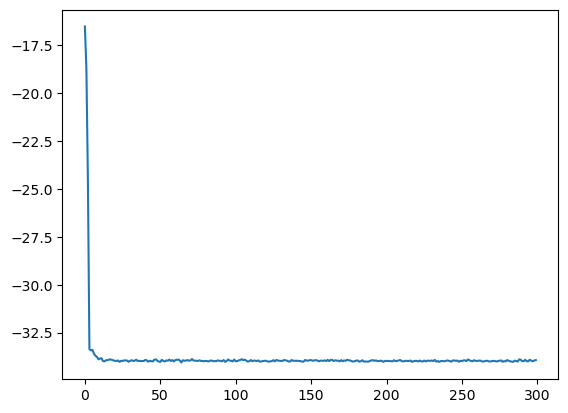

In [44]:
# plot data
plt.plot(logger.data['Energy']['iters'], logger.data['Energy']['Mean'])

In [45]:
#Dense network implementation
# Implement a feedforward neural network with two hidden layers and ReLU activations.

class FFN(nn.Module):
    @nn.compact
    def __call__(self, x):
        # First dense layer
        x = nn.Dense(features=hi.size)(x)
        x = nn.relu(x)
        
        # Second dense layer
        x = nn.Dense(features=hi.size)(x)
        x = nn.relu(x)
        
        # Final dense layer with a single output unit for the last dimension
        x = nn.Dense(features=1)(x)  # Produces shape (20, 100, 1)
        
        # Squeeze the last dimension to match the desired output shape
        x = x.squeeze(axis=-1)  # Results in shape (20, 100)
        return x

100%|██████████| 1000/1000 [00:09<00:00, 105.82it/s]


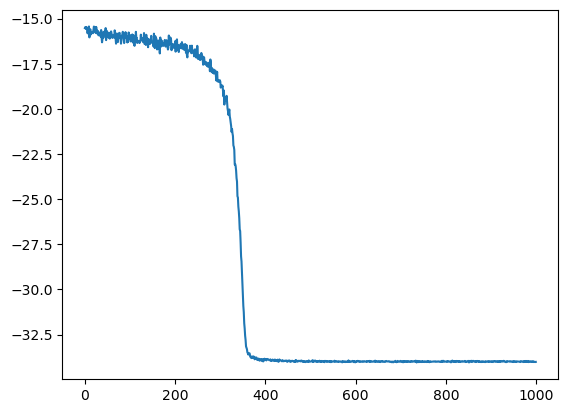

In [46]:
# compute the ground state with an SGD optimization using NN ( increased n_iters to 1000)

from tqdm import tqdm

# settings 
model = FFN()
sampler = nk.sampler.MetropolisSampler(
                        hi,                            # the hilbert space to be sampled
                        nk.sampler.rules.LocalRule(),  # the transition rule
                        n_chains = 20)
n_iters = 1000
chain_length = 1000//sampler.n_chains

# initialise
parameters = model.init(jax.random.key(0), np.ones((hi.size, )))
#parameters = model.init(jax.random.PRNGKey(0), np.ones((1, hi.size)))
sampler_state = sampler.init_state(model, parameters, seed=1)

# logging: you can (if you want) use netket loggers to avoid writing a lot of boilerplate...
# they accumulate data you throw at them
logger = nk.logging.RuntimeLog()

for i in tqdm(range(n_iters)):
    # sample
    sampler_state = sampler.reset(model, parameters, state=sampler_state)
    samples, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=chain_length)
    
    # compute energy and gradient
    E, E_grad = estimate_energy_and_gradient(model, parameters, hamiltonian_jax, samples)
    
    # update parameters. Try using a learning rate of 0.01
    parameters = jax.tree.map(lambda x,y: x-0.005*y, parameters, E_grad)
    
    # log energy: the logger takes a step argument and a dictionary of variables to be logged
    logger(step=i, item={'Energy':E})

plt.plot(logger.data['Energy']['iters'], logger.data['Energy']['Mean'])